# Inferencia de Segmentación Pulmonar - Aplicación del Modelo U-Net Entrenado

Este notebook utiliza el modelo U-Net entrenado previamente para generar predicciones de segmentación pulmonar en las imágenes de rayos X de tórax identificadas en el análisis exploratorio.

## Objetivos

1. **Cargar el modelo entrenado** desde el checkpoint guardado
2. **Procesar las imágenes** del CSV de radiografías de tórax
3. **Generar predicciones** de segmentación pulmonar
4. **Visualizar resultados** y métricas de calidad
5. **Guardar las máscaras predichas** para uso posterior

## Flujo de Trabajo

- Cargar modelo U-Net pre-entrenado con PyTorch/MONAI
- Procesar imágenes del dataset filtrado
- Aplicar transformaciones consistentes con el entrenamiento
- Generar máscaras de segmentación
- Evaluar calidad visual de las predicciones

In [11]:
# Importaciones necesarias
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from pathlib import Path
from tqdm import tqdm
import json
import warnings
warnings.filterwarnings('ignore')

# MONAI imports
from monai.networks.nets import UNet
from monai.transforms import Compose, Resize, ScaleIntensity
from monai.utils import set_determinism

# Set determinism for reproducible results
set_determinism(seed=42)

# Verificar disponibilidad de GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# Configurar rutas
DATA_DIR = Path('../data')
IMAGES_DIR = DATA_DIR
MODEL_PATH = 'best_unet_model_clahe.pth'
CSV_PATH = DATA_DIR / 'chest_xray_filenames.csv'
OUTPUT_DIR = Path('../output/predictions')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"Directorio de datos: {DATA_DIR.absolute()}")
print(f"Directorio de salida: {OUTPUT_DIR.absolute()}")

Usando dispositivo: cpu
Directorio de datos: c:\Users\franco\Code\challenge\notebooks\..\data
Directorio de salida: c:\Users\franco\Code\challenge\notebooks\..\output\predictions


## Cargar Modelo Pre-entrenado

Recreamos la arquitectura del modelo y cargamos los pesos entrenados desde el checkpoint.

In [12]:
def create_unet_model(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    channels=(64, 128, 256, 512),
    strides=(2, 2, 2),
    num_res_units=2,
):
    """
    Crear el mismo modelo U-Net usado en el entrenamiento
    """
    model = UNet(
        spatial_dims=spatial_dims,
        in_channels=in_channels,
        out_channels=out_channels,
        channels=channels,
        strides=strides,
        num_res_units=num_res_units,
        norm='batch',
        dropout=0.1,
    )
    return model

def load_trained_model(model_path, device):
    """
    Cargar el modelo entrenado desde el checkpoint
    """
    # Crear el modelo
    model = create_unet_model()
    
    try:
        # Cargar checkpoint
        checkpoint = torch.load(model_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        
        # Información del checkpoint
        epoch = checkpoint.get('epoch', 'Unknown')
        best_dice = checkpoint.get('best_val_dice', 'Unknown')
        
        model = model.to(device)
        model.eval()
        
        print(f"✅ Modelo cargado exitosamente!")
        print(f"   - Época: {epoch}")
        print(f"   - Mejor Dice de validación: {best_dice:.4f}")
        print(f"   - Parámetros: {sum(p.numel() for p in model.parameters()):,}")
        
        return model, checkpoint
        
    except FileNotFoundError:
        print(f"❌ No se encontró el archivo del modelo: {model_path}")
        print("Asegúrate de haber ejecutado el entrenamiento primero.")
        return None, None
    except Exception as e:
        print(f"❌ Error al cargar el modelo: {str(e)}")
        return None, None

# Cargar el modelo entrenado
model, checkpoint = load_trained_model(MODEL_PATH, device)

if model is None:
    print(f"⚠️  No se pudo cargar el modelo. Verifica que existe el archivo {MODEL_PATH}")

✅ Modelo cargado exitosamente!
   - Época: 1
   - Mejor Dice de validación: 0.9483
   - Parámetros: 6,408,154


## Cargar Dataset de Imágenes

Cargamos el CSV con las imágenes de radiografías de tórax identificadas en el análisis exploratorio.

In [13]:
# Cargar CSV con filenames de radiografías de tórax
try:
    chest_df = pd.read_csv(CSV_PATH)
    print(f"✅ CSV cargado exitosamente: {len(chest_df)} imágenes")
    print(f"Columnas disponibles: {list(chest_df.columns)}")
    print(f"\nPrimeras 5 filas:")
    print(chest_df.head())
    
except FileNotFoundError:
    print(f"❌ No se encontró el archivo CSV: {CSV_PATH}")
    print("Asegúrate de haber ejecutado el notebook de exploración primero.")
    chest_df = None

if chest_df is not None:
    # Estadísticas del dataset
    print(f"\n📊 Estadísticas del Dataset:")
    print(f"   - Total de imágenes: {len(chest_df)}")
    print(f"   - Modalidades: {chest_df['modalities'].value_counts().to_dict()}")
    print(f"   - Partes del cuerpo más comunes:")
    print(f"     {chest_df['body_parts'].value_counts().head(5).to_dict()}")
    
    # Verificar cuántas imágenes existen físicamente
    existing_images = []
    for idx, row in chest_df.iterrows():
        img_path = IMAGES_DIR / row['filename']
        if img_path.exists():
            existing_images.append(idx)
    
    print(f"   - Imágenes existentes en disco: {len(existing_images)}/{len(chest_df)}")
    
    # Filtrar solo imágenes existentes
    chest_df_filtered = chest_df.iloc[existing_images].copy()
    print(f"   - Dataset filtrado: {len(chest_df_filtered)} imágenes")

✅ CSV cargado exitosamente: 311 imágenes
Columnas disponibles: ['filename', 'study_id', 'instance_id', 'body_parts', 'modalities', 'patient_age', 'patient_gender']

Primeras 5 filas:
       filename                              study_id  \
0  9988B8C4.jpg  00b5f7cf-1ef4-43bc-a8b8-0f36a15f4b5e   
1    280001.jpg  00ea3632-3e1d-4a7d-82ab-97396b8bad0c   
2  E138AA87.jpg  00f65e49-5127-4149-9af2-f06a97d3e84a   
3  35236841.jpg  026ba6b1-8231-4432-ba18-d7e3a9ca0992   
4  48137D7A.jpg  029733ba-e2f4-421f-b37e-50fdf4b221f6   

                            instance_id     body_parts modalities  \
0  251fd155-c42a-4603-a8a5-e48e00e381d1          CHEST         CR   
1  a2ed1a74-412d-4a99-890c-2d6288d1298a  CHEST,L SPINE         DX   
2  260a442c-8ff3-4c9f-bd2d-7ab7b5653d2d          CHEST         CR   
3  75e6701f-24d4-45eb-aa2f-0264361bae3c          CHEST         CR   
4  8bee02e9-e116-4c3e-841b-21c74e38f271       Pectoral         DX   

   patient_age patient_gender  
0         67.0             

## Configurar Transformaciones para Inferencia

Definimos las mismas transformaciones usadas durante la validación del modelo.

In [14]:
# Configurar transformaciones para inferencia (mismas que validación)
def create_inference_transforms(target_size=(64, 64)):
    """
    Crear transformaciones para inferencia
    Deben ser consistentes con las usadas en validación
    """
    transforms = Compose([
        Resize(spatial_size=target_size),
        ScaleIntensity(minv=0.0, maxv=1.0),
    ])
    return transforms

def detect_and_correct_inversion(image):
    """
    Detecta y corrige la inversión de una imagen basándose en el valor promedio de las esquinas.
    
    Args:
        image: Imagen en escala de grises (numpy array)
    
    Returns:
        Tuple: (imagen_corregida, fue_invertida)
    """
    if len(image.shape) != 2:
        raise ValueError("La imagen debe ser en escala de grises (2D)")
    
    height, width = image.shape
    corner_size = min(20, height // 10, width // 10)  # Tamaño de esquina adaptativo
    
    # Extraer las cuatro esquinas
    top_left = image[:corner_size, :corner_size]
    top_right = image[:corner_size, -corner_size:]
    bottom_left = image[-corner_size:, :corner_size]
    bottom_right = image[-corner_size:, -corner_size:]
    
    # Calcular el valor promedio de todas las esquinas
    corners_mean = np.mean([
        np.mean(top_left),
        np.mean(top_right),
        np.mean(bottom_left),
        np.mean(bottom_right)
    ])
    
    # Determinar el valor máximo de la imagen
    max_value = np.max(image)
    
    # Umbral para detectar inversión (50% del valor máximo)
    inversion_threshold = 0.5 * max_value
    
    # Si el promedio de las esquinas es alto, la imagen está invertida
    is_inverted = corners_mean > inversion_threshold
    
    if is_inverted:
        # Invertir la imagen matemáticamente
        corrected_image = max_value - image
        return corrected_image, True
    else:
        return image, False

def preprocess_image(image_path, transforms=None, target_size=(64, 64)):
    """
    Preprocesar una imagen para inferencia con detección y corrección de inversión
    """
    try:
        # Cargar imagen
        image = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
        if image is None:
            return None
        
        # NUEVO: Detectar y corregir inversión antes de cualquier otro procesamiento
        image, was_inverted = detect_and_correct_inversion(image)
        
        # Redimensionar con OpenCV (consistente con entrenamiento)
        image = cv2.resize(image, target_size, interpolation=cv2.INTER_AREA)
        
        # Normalizar
        image = image.astype(np.float32) / 255.0
        
        # Agregar dimensión de canal
        image = np.expand_dims(image, axis=0)  # (1, H, W)
        
        # Convertir a tensor
        image = torch.from_numpy(image.astype(np.float32))
        
        # Agregar dimensión de batch
        image = image.unsqueeze(0)  # (1, 1, H, W)
        
        return image
        
    except Exception as e:
        print(f"Error procesando imagen {image_path}: {str(e)}")
        return None

# Configurar parámetros de inferencia
TARGET_SIZE = (64, 64)  # Mismo tamaño usado en entrenamiento
BATCH_SIZE = 16  # Procesar múltiples imágenes a la vez

print(f"⚙️  Configuración de inferencia:")
print(f"   - Tamaño objetivo: {TARGET_SIZE}")
print(f"   - Tamaño de batch: {BATCH_SIZE}")
print(f"   - Dispositivo: {device}")

⚙️  Configuración de inferencia:
   - Tamaño objetivo: (64, 64)
   - Tamaño de batch: 16
   - Dispositivo: cpu


## Función de Inferencia

Implementamos la función principal para generar predicciones de segmentación.

In [15]:
def predict_single_image(model, image_tensor, device):
    """
    Generar predicción para una sola imagen
    """
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        
        # Forward pass
        output = model(image_tensor)
        
        # Aplicar sigmoid para obtener probabilidades
        prediction = torch.sigmoid(output)
        
        # Convertir a numpy
        prediction = prediction.cpu().numpy()
        
        return prediction

def predict_batch(model, image_paths, device, target_size=(64, 64)):
    """
    Generar predicciones para un batch de imágenes con detección de inversión
    """
    results = []
    
    for img_path in image_paths:
        # Preprocesar imagen (ahora incluye detección de inversión)
        image_tensor = preprocess_image(img_path, target_size=target_size)
        
        if image_tensor is not None:
            # Generar predicción
            prediction = predict_single_image(model, image_tensor, device)
            
            # Extraer máscara (remover dimensiones de batch y canal)
            mask = prediction[0, 0]  # (H, W)
            
            results.append({
                'image_path': str(img_path),
                'prediction': mask,
                'success': True
            })
        else:
            results.append({
                'image_path': str(img_path),
                'prediction': None,
                'success': False
            })
    
    return results

def calculate_prediction_stats(mask, threshold=0.5):
    """
    Calcular estadísticas de la predicción
    """
    binary_mask = (mask > threshold).astype(np.float32)
    
    stats = {
        'mean_confidence': float(mask.mean()),
        'max_confidence': float(mask.max()),
        'min_confidence': float(mask.min()),
        'lung_area_ratio': float(binary_mask.mean()),
        'total_pixels': int(mask.size),
        'lung_pixels': int(binary_mask.sum())
    }
    
    return stats

print("✅ Funciones de inferencia definidas")

✅ Funciones de inferencia definidas


## Generar Predicciones en el Dataset

Aplicamos el modelo a todas las imágenes del dataset filtrado.

In [16]:
if model is not None and chest_df_filtered is not None:
    print("🔮 Iniciando generación de predicciones...")
    
    # Preparar listas para resultados
    all_predictions = []
    prediction_stats = []
    failed_predictions = []
    
    # Procesar imágenes en batches
    batch_size = BATCH_SIZE
    total_images = len(chest_df_filtered)
    
    for i in tqdm(range(0, total_images, batch_size), desc="Procesando batches"):
        batch_end = min(i + batch_size, total_images)
        batch_df = chest_df_filtered.iloc[i:batch_end]
        
        # Obtener rutas de imágenes del batch
        batch_paths = [IMAGES_DIR / row['filename'] for _, row in batch_df.iterrows()]
        
        # Generar predicciones para el batch
        batch_results = predict_batch(model, batch_paths, device, TARGET_SIZE)
        
        # Procesar resultados
        for j, result in enumerate(batch_results):
            row_idx = i + j
            row = chest_df_filtered.iloc[row_idx]
            
            if result['success']:
                mask = result['prediction']
                stats = calculate_prediction_stats(mask)
                
                # Agregar información adicional
                prediction_data = {
                    'filename': row['filename'],
                    'study_id': row['study_id'],
                    'instance_id': row['instance_id'],
                    'body_parts': row['body_parts'],
                    'modalities': row['modalities'],
                    'patient_age': row['patient_age'],
                    'patient_gender': row['patient_gender'],
                    **stats
                }
                
                all_predictions.append(prediction_data)
                prediction_stats.append(mask)
                
            else:
                failed_predictions.append({
                    'filename': row['filename'],
                    'error': 'Failed to process image'
                })
    
    print(f"✅ Predicciones completadas!")
    print(f"   - Exitosas: {len(all_predictions)}")
    print(f"   - Fallidas: {len(failed_predictions)}")
    
    # Crear DataFrame con resultados
    predictions_df = pd.DataFrame(all_predictions)
    
    print(f"\n📊 Estadísticas de Predicciones:")
    if len(predictions_df) > 0:
        print(f"   - Confianza promedio: {predictions_df['mean_confidence'].mean():.3f}")
        print(f"   - Proporción pulmonar promedio: {predictions_df['lung_area_ratio'].mean():.3f}")
        print(f"   - Rango de confianza: {predictions_df['mean_confidence'].min():.3f} - {predictions_df['mean_confidence'].max():.3f}")
        
    # Mostrar fallos si los hay
    if failed_predictions:
        print(f"\n⚠️  Predicciones fallidas:")
        for fail in failed_predictions[:5]:  # Mostrar solo las primeras 5
            print(f"   - {fail['filename']}: {fail['error']}")

else:
    print("❌ No se puede proceder: modelo o dataset no disponibles")
    predictions_df = None
    prediction_stats = []

🔮 Iniciando generación de predicciones...


Procesando batches:  89%|████████▉ | 17/19 [00:11<00:01,  1.53it/s]


KeyboardInterrupt: 

## Visualización de Resultados

Mostramos ejemplos de predicciones y análisis de calidad.

📈 Generando visualizaciones...


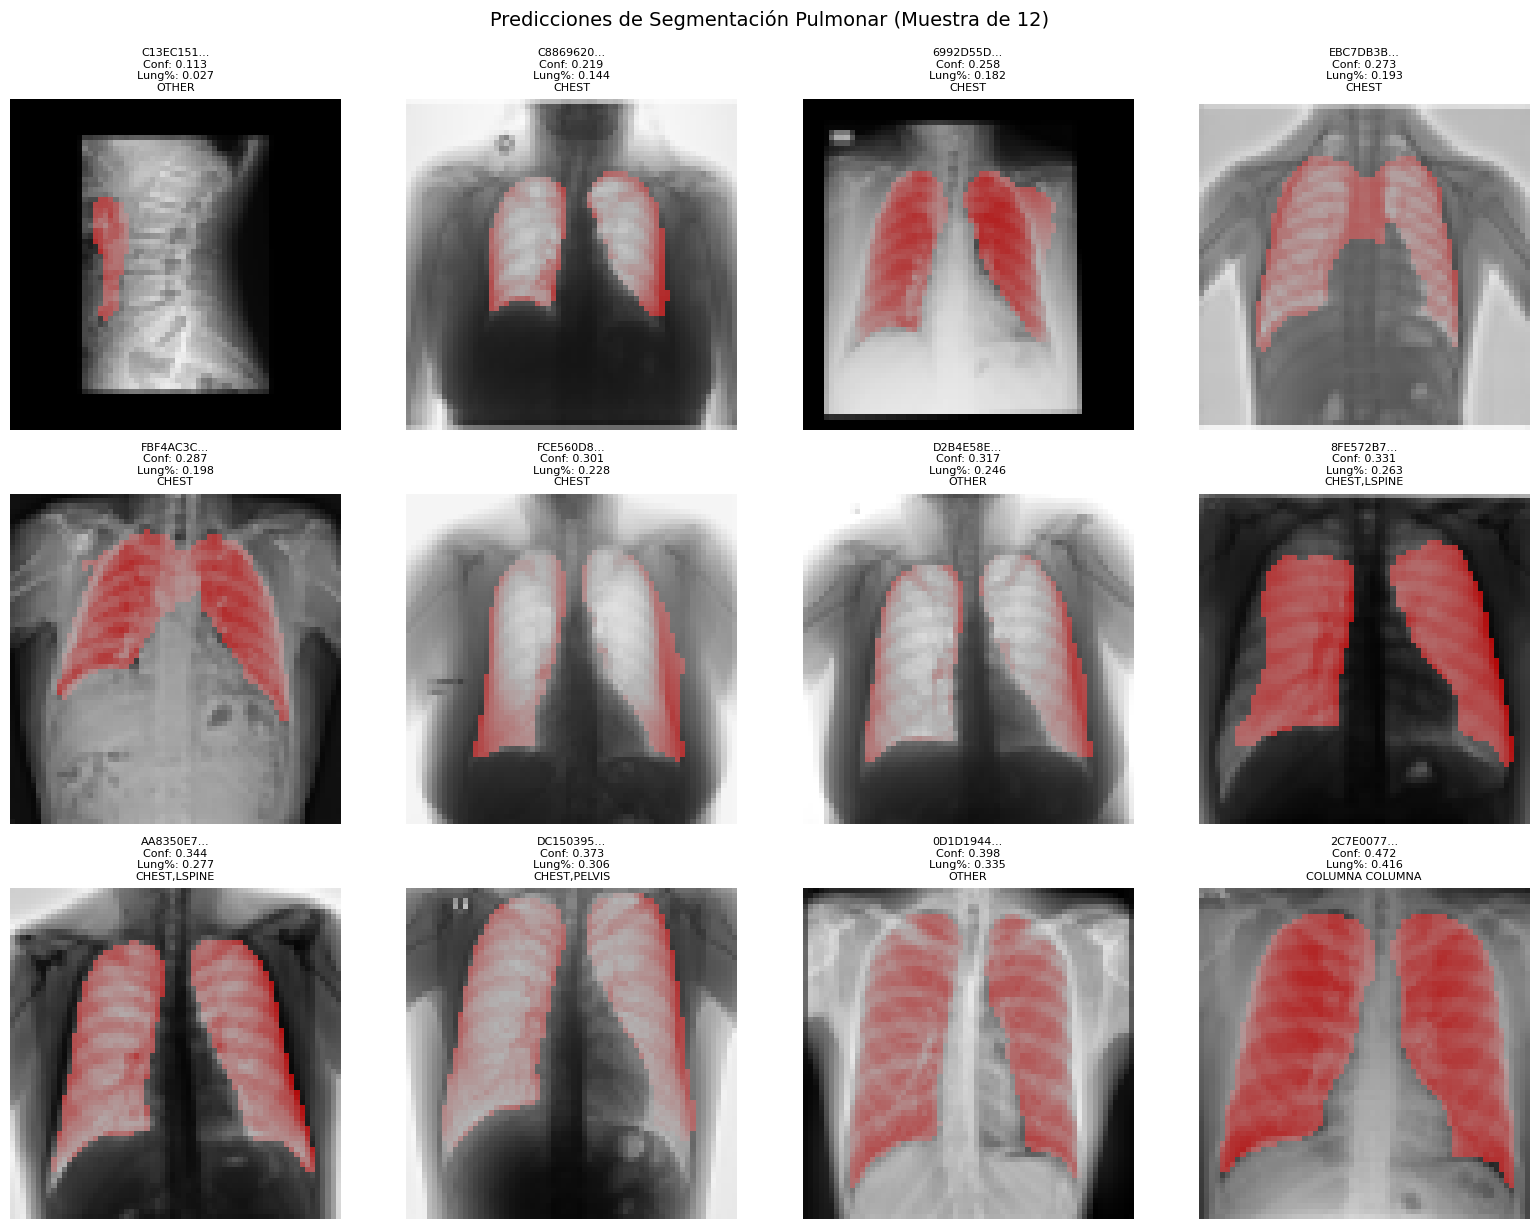

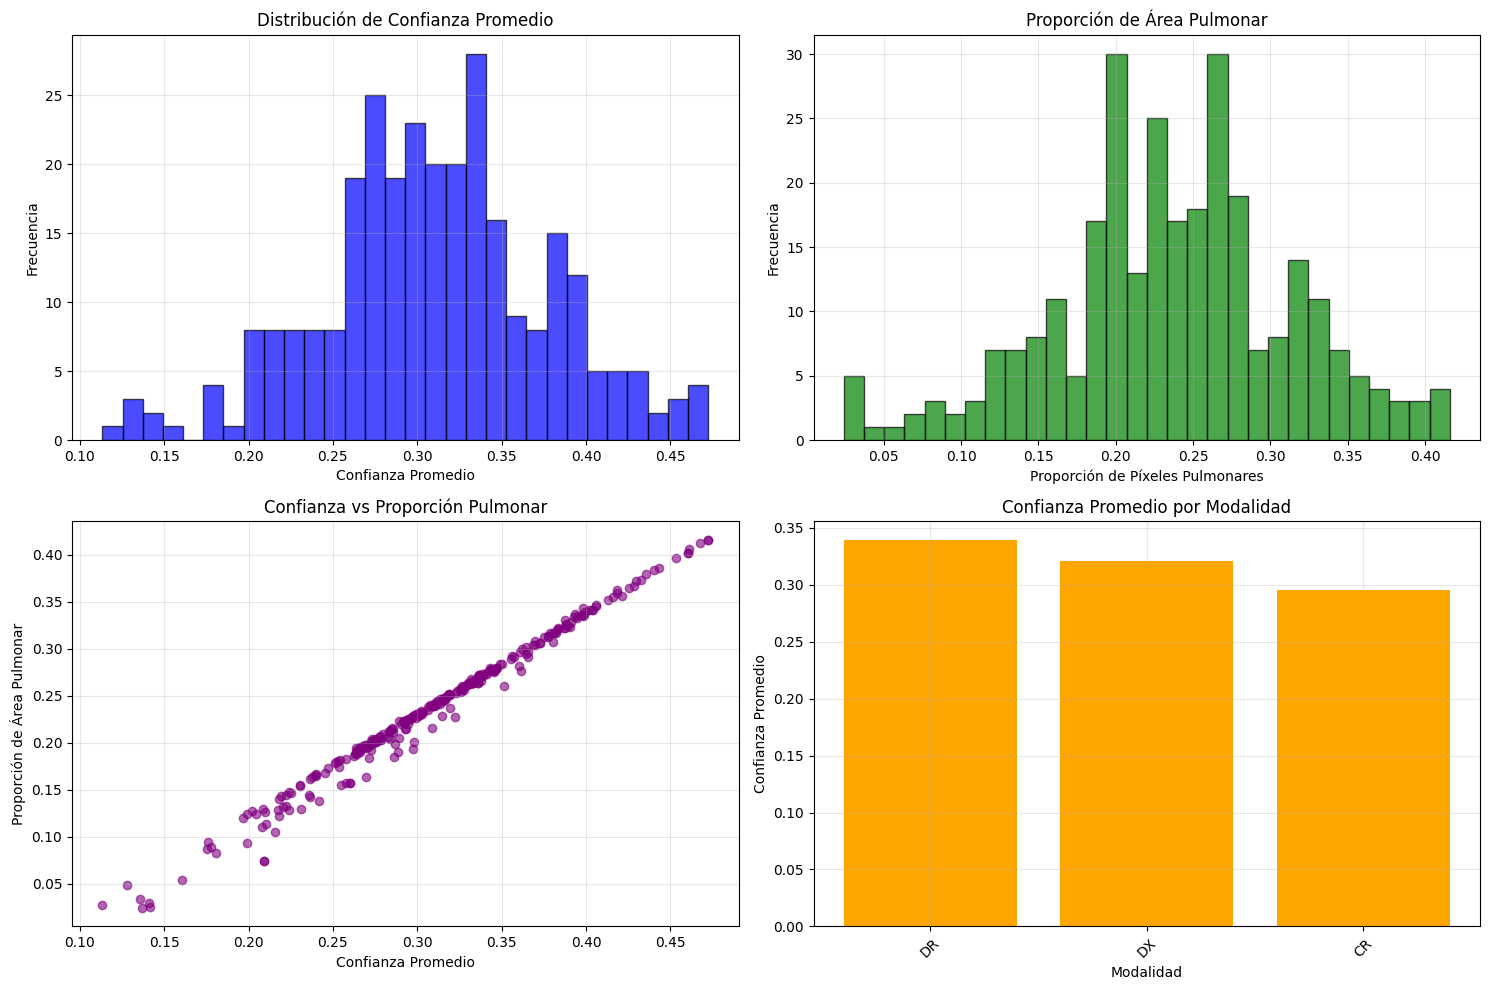

In [ ]:
def visualize_predictions(predictions_df, prediction_stats, num_samples=12, cols=4):
    """
    Visualizar muestras de predicciones
    """
    if len(predictions_df) == 0:
        print("No hay predicciones para visualizar")
        return
    
    # Seleccionar muestras variadas
    n_samples = min(num_samples, len(predictions_df))
    
    # Estratificar por confianza para mostrar variedad
    predictions_df_sorted = predictions_df.sort_values('mean_confidence')
    indices = np.linspace(0, len(predictions_df_sorted)-1, n_samples, dtype=int)
    sample_df = predictions_df_sorted.iloc[indices]
    
    rows = int(np.ceil(n_samples / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*4))
    if rows == 1:
        axes = axes.reshape(1, -1)
    
    for idx, (_, row) in enumerate(sample_df.iterrows()):
        row_idx = idx // cols
        col_idx = idx % cols
        ax = axes[row_idx, col_idx]
        
        # Cargar imagen original
        img_path = IMAGES_DIR / row['filename']
        try:
            original_img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
            original_img = cv2.resize(original_img, TARGET_SIZE, interpolation=cv2.INTER_AREA)
            
            # Obtener predicción correspondiente
            pred_idx = predictions_df.index[predictions_df['filename'] == row['filename']].tolist()[0]
            mask_idx = list(predictions_df.index).index(pred_idx)
            predicted_mask = prediction_stats[mask_idx]
            
            # Crear visualización combinada
            # Imagen original en escala de grises
            combined = np.stack([original_img/255.0] * 3, axis=-1)
            
            # Superponer máscara predicha en rojo
            mask_binary = (predicted_mask > 0.5).astype(np.float32)
            combined[:, :, 0] = np.maximum(combined[:, :, 0], mask_binary * 0.7)
            
            ax.imshow(combined)
            ax.set_title(f"{row['filename'][:8]}...\n"
                        f"Conf: {row['mean_confidence']:.3f}\n"
                        f"Lung%: {row['lung_area_ratio']:.3f}\n"
                        f"{row['body_parts'][:15]}", fontsize=8)
            ax.axis('off')
            
        except Exception as e:
            ax.text(0.5, 0.5, f'Error:\n{str(e)[:30]}...', 
                   ha='center', va='center', transform=ax.transAxes)
            ax.axis('off')
    
    # Ocultar axes vacíos
    for idx in range(n_samples, rows * cols):
        row_idx = idx // cols
        col_idx = idx % cols
        axes[row_idx, col_idx].axis('off')
    
    plt.tight_layout()
    plt.suptitle(f'Predicciones de Segmentación Pulmonar (Muestra de {n_samples})', 
                 fontsize=14, y=1.02)
    plt.show()

def plot_prediction_statistics(predictions_df):
    """
    Graficar estadísticas de las predicciones
    """
    if len(predictions_df) == 0:
        print("No hay datos para graficar")
        return
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Distribución de confianza
    axes[0, 0].hist(predictions_df['mean_confidence'], bins=30, alpha=0.7, color='blue', edgecolor='black')
    axes[0, 0].set_title('Distribución de Confianza Promedio')
    axes[0, 0].set_xlabel('Confianza Promedio')
    axes[0, 0].set_ylabel('Frecuencia')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Distribución de proporción pulmonar
    axes[0, 1].hist(predictions_df['lung_area_ratio'], bins=30, alpha=0.7, color='green', edgecolor='black')
    axes[0, 1].set_title('Proporción de Área Pulmonar')
    axes[0, 1].set_xlabel('Proporción de Píxeles Pulmonares')
    axes[0, 1].set_ylabel('Frecuencia')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Confianza vs Proporción pulmonar
    axes[1, 0].scatter(predictions_df['mean_confidence'], predictions_df['lung_area_ratio'], 
                      alpha=0.6, c='purple')
    axes[1, 0].set_title('Confianza vs Proporción Pulmonar')
    axes[1, 0].set_xlabel('Confianza Promedio')
    axes[1, 0].set_ylabel('Proporción de Área Pulmonar')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Distribución por modalidad
    if 'modalities' in predictions_df.columns:
        modality_stats = predictions_df.groupby('modalities')['mean_confidence'].mean().sort_values(ascending=False)
        axes[1, 1].bar(range(len(modality_stats)), modality_stats.values, color='orange')
        axes[1, 1].set_title('Confianza Promedio por Modalidad')
        axes[1, 1].set_xlabel('Modalidad')
        axes[1, 1].set_ylabel('Confianza Promedio')
        axes[1, 1].set_xticks(range(len(modality_stats)))
        axes[1, 1].set_xticklabels(modality_stats.index, rotation=45)
        axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Generar visualizaciones
if predictions_df is not None and len(predictions_df) > 0:
    print("📈 Generando visualizaciones...")
    
    # Visualizar muestras de predicciones
    visualize_predictions(predictions_df, prediction_stats, num_samples=12, cols=4)
    
    # Graficar estadísticas
    plot_prediction_statistics(predictions_df)
    
else:
    print("❌ No hay datos para visualizar")

## Análisis de Calidad de Predicciones

Evaluamos la calidad de las predicciones generadas.

In [ ]:
def analyze_prediction_quality(predictions_df):
    """
    Analizar la calidad de las predicciones generadas
    """
    if len(predictions_df) == 0:
        print("No hay predicciones para analizar")
        return
    
    print("🔍 ANÁLISIS DE CALIDAD DE PREDICCIONES")
    print("=" * 50)
    
    # Estadísticas generales
    print(f"\n📊 Estadísticas Generales:")
    print(f"   - Total de predicciones: {len(predictions_df)}")
    print(f"   - Confianza promedio: {predictions_df['mean_confidence'].mean():.4f} ± {predictions_df['mean_confidence'].std():.4f}")
    print(f"   - Proporción pulmonar promedio: {predictions_df['lung_area_ratio'].mean():.4f} ± {predictions_df['lung_area_ratio'].std():.4f}")
    
    # Análisis por modalidad
    print(f"\n🏥 Análisis por Modalidad:")
    modality_analysis = predictions_df.groupby('modalities').agg({
        'mean_confidence': ['mean', 'std', 'count'],
        'lung_area_ratio': ['mean', 'std']
    }).round(4)
    print(modality_analysis)
    
    # Identificar predicciones de alta y baja confianza
    high_conf_threshold = predictions_df['mean_confidence'].quantile(0.8)
    low_conf_threshold = predictions_df['mean_confidence'].quantile(0.2)
    
    high_conf_predictions = predictions_df[predictions_df['mean_confidence'] >= high_conf_threshold]
    low_conf_predictions = predictions_df[predictions_df['mean_confidence'] <= low_conf_threshold]
    
    print(f"\n🎯 Análisis de Confianza:")
    print(f"   - Predicciones alta confianza (>={high_conf_threshold:.3f}): {len(high_conf_predictions)} ({len(high_conf_predictions)/len(predictions_df)*100:.1f}%)")
    print(f"   - Predicciones baja confianza (<={low_conf_threshold:.3f}): {len(low_conf_predictions)} ({len(low_conf_predictions)/len(predictions_df)*100:.1f}%)")
    
    # Análisis de detección pulmonar
    detected_lungs = predictions_df[predictions_df['lung_area_ratio'] > 0.01]  # Al menos 1% del área
    no_lungs_detected = predictions_df[predictions_df['lung_area_ratio'] <= 0.01]
    
    print(f"\n🫁 Análisis de Detección Pulmonar:")
    print(f"   - Imágenes con pulmones detectados: {len(detected_lungs)} ({len(detected_lungs)/len(predictions_df)*100:.1f}%)")
    print(f"   - Imágenes sin pulmones detectados: {len(no_lungs_detected)} ({len(no_lungs_detected)/len(predictions_df)*100:.1f}%)")
    
    if len(no_lungs_detected) > 0:
        print(f"   - Tipos de imágenes sin detección:")
        no_detection_types = no_lungs_detected['body_parts'].value_counts().head(5)
        for body_part, count in no_detection_types.items():
            print(f"     * {body_part}: {count}")
    
    # Análisis por edad (si disponible)
    age_available = predictions_df['patient_age'].notna()
    if age_available.sum() > 0:
        age_data = predictions_df[age_available].copy()
        age_data['age_group'] = pd.cut(age_data['patient_age'], 
                                     bins=[0, 18, 35, 50, 65, 100], 
                                     labels=['0-17', '18-34', '35-49', '50-64', '65+'])
        
        print(f"\n👥 Análisis por Grupo de Edad:")
        age_analysis = age_data.groupby('age_group').agg({
            'mean_confidence': 'mean',
            'lung_area_ratio': 'mean'
        }).round(4)
        print(age_analysis)
    
    return {
        'total_predictions': len(predictions_df),
        'mean_confidence': predictions_df['mean_confidence'].mean(),
        'mean_lung_ratio': predictions_df['lung_area_ratio'].mean(),
        'high_confidence_count': len(high_conf_predictions),
        'low_confidence_count': len(low_conf_predictions),
        'lungs_detected_count': len(detected_lungs)
    }

# Realizar análisis de calidad
if predictions_df is not None and len(predictions_df) > 0:
    quality_metrics = analyze_prediction_quality(predictions_df)
else:
    print("❌ No hay predicciones para analizar")
    quality_metrics = None

🔍 ANÁLISIS DE CALIDAD DE PREDICCIONES

📊 Estadísticas Generales:
   - Total de predicciones: 290
   - Confianza promedio: 0.3097 ± 0.0671
   - Proporción pulmonar promedio: 0.2366 ± 0.0767

🏥 Análisis por Modalidad:
           mean_confidence               lung_area_ratio        
                      mean     std count            mean     std
modalities                                                      
CR                  0.2958  0.0564   136          0.2223  0.0647
DR                  0.3390  0.1060    10          0.2629  0.1190
DX                  0.3208  0.0708   144          0.2483  0.0815

🎯 Análisis de Confianza:
   - Predicciones alta confianza (>=0.365): 58 (20.0%)
   - Predicciones baja confianza (<=0.264): 58 (20.0%)

🫁 Análisis de Detección Pulmonar:
   - Imágenes con pulmones detectados: 290 (100.0%)
   - Imágenes sin pulmones detectados: 0 (0.0%)

👥 Análisis por Grupo de Edad:
           mean_confidence  lung_area_ratio
age_group                                  
0-17

## Guardar Resultados

Guardamos las predicciones y estadísticas para uso posterior.

In [ ]:
def save_predictions(predictions_df, prediction_stats, output_dir):
    """
    Guardar resultados de predicciones
    """
    if predictions_df is None or len(predictions_df) == 0:
        print("No hay predicciones para guardar")
        return
    
    print("💾 Guardando resultados...")
    
    # 1. Guardar DataFrame con estadísticas
    stats_path = output_dir / 'prediction_statistics.csv'
    predictions_df.to_csv(stats_path, index=False)
    print(f"   ✅ Estadísticas guardadas: {stats_path}")
    
    # 2. Guardar resumen JSON
    summary = {
        'total_predictions': len(predictions_df),
        'successful_predictions': len(predictions_df),
        'failed_predictions': len(failed_predictions) if 'failed_predictions' in globals() else 0,
        'model_info': {
            'model_path': MODEL_PATH,
            'target_size': TARGET_SIZE,
            'device': str(device)
        },
        'statistics': {
            'mean_confidence': float(predictions_df['mean_confidence'].mean()),
            'std_confidence': float(predictions_df['mean_confidence'].std()),
            'mean_lung_ratio': float(predictions_df['lung_area_ratio'].mean()),
            'std_lung_ratio': float(predictions_df['lung_area_ratio'].std())
        },
        'modalities': predictions_df['modalities'].value_counts().to_dict(),
        'body_parts': predictions_df['body_parts'].value_counts().head(10).to_dict()
    }
    
    summary_path = output_dir / 'prediction_summary.json'
    with open(summary_path, 'w') as f:
        json.dump(summary, f, indent=2)
    print(f"   ✅ Resumen guardado: {summary_path}")
    
    # 3. Guardar máscaras de alta confianza como ejemplos
    high_conf_threshold = predictions_df['mean_confidence'].quantile(0.9)
    high_conf_samples = predictions_df[predictions_df['mean_confidence'] >= high_conf_threshold].head(10)
    
    masks_dir = output_dir / 'sample_masks'
    masks_dir.mkdir(exist_ok=True)
    
    for idx, (_, row) in enumerate(high_conf_samples.iterrows()):
        try:
            # Encontrar la máscara correspondiente
            pred_idx = predictions_df.index[predictions_df['filename'] == row['filename']].tolist()[0]
            mask_idx = list(predictions_df.index).index(pred_idx)
            mask = prediction_stats[mask_idx]
            
            # Guardar máscara
            mask_filename = f"{row['filename'].replace('.jpg', '')}_mask.png"
            mask_path = masks_dir / mask_filename
            
            # Convertir a imagen de 8 bits
            mask_uint8 = (mask * 255).astype(np.uint8)
            cv2.imwrite(str(mask_path), mask_uint8)
            
        except Exception as e:
            print(f"   ⚠️  Error guardando máscara {row['filename']}: {str(e)}")
    
    print(f"   ✅ Máscaras de muestra guardadas: {masks_dir}")
    
    print(f"\n📁 Todos los resultados guardados en: {output_dir.absolute()}")

# Guardar resultados
if predictions_df is not None and len(predictions_df) > 0:
    save_predictions(predictions_df, prediction_stats, OUTPUT_DIR)
else:
    print("❌ No hay resultados para guardar")

💾 Guardando resultados...
   ✅ Estadísticas guardadas: ..\output\predictions\prediction_statistics.csv
   ✅ Resumen guardado: ..\output\predictions\prediction_summary.json
   ✅ Máscaras de muestra guardadas: ..\output\predictions\sample_masks

📁 Todos los resultados guardados en: c:\Users\franco\Code\challenge\notebooks\..\output\predictions


## Resumen Final

Resumen completo de la inferencia realizada.

In [ ]:
print("="*60)
print("RESUMEN DE INFERENCIA - SEGMENTACIÓN PULMONAR")
print("="*60)

if model is not None and predictions_df is not None:
    print(f"\n🎯 RESULTADOS DE INFERENCIA:")
    print(f"   ✅ Modelo cargado exitosamente")
    print(f"   ✅ Predicciones generadas: {len(predictions_df)}")
    if 'failed_predictions' in globals():
        print(f"   ⚠️  Predicciones fallidas: {len(failed_predictions)}")
    
    print(f"\n📊 MÉTRICAS DE CALIDAD:")
    print(f"   - Confianza promedio: {predictions_df['mean_confidence'].mean():.4f}")
    print(f"   - Proporción pulmonar promedio: {predictions_df['lung_area_ratio'].mean():.4f}")
    print(f"   - Rango de confianza: [{predictions_df['mean_confidence'].min():.3f}, {predictions_df['mean_confidence'].max():.3f}]")
    
    print(f"\n🏥 COBERTURA DEL DATASET:")
    print(f"   - Modalidades procesadas: {', '.join(predictions_df['modalities'].unique())}")
    print(f"   - Tipos de estudios: {len(predictions_df['body_parts'].unique())} diferentes")
    
    print(f"\n💾 ARCHIVOS GENERADOS:")
    print(f"   - Estadísticas: prediction_statistics.csv")
    print(f"   - Resumen: prediction_summary.json")
    print(f"   - Máscaras de muestra: sample_masks/")
    
    print(f"\n🔍 RECOMENDACIONES:")
    high_conf_count = len(predictions_df[predictions_df['mean_confidence'] > 0.7])
    low_conf_count = len(predictions_df[predictions_df['mean_confidence'] < 0.3])
    
    if high_conf_count > len(predictions_df) * 0.7:
        print(f"   ✅ Buena calidad general de predicciones ({high_conf_count/len(predictions_df)*100:.1f}% alta confianza)")
    elif low_conf_count > len(predictions_df) * 0.3:
        print(f"   ⚠️  Revisar predicciones de baja confianza ({low_conf_count/len(predictions_df)*100:.1f}%)")
    else:
        print(f"   ℹ️  Calidad mixta de predicciones - revisar casos individuales")

else:
    print(f"\n❌ INFERENCIA NO COMPLETADA:")
    if model is None:
        print(f"   - No se pudo cargar el modelo entrenado")
    if 'chest_df_filtered' not in globals() or chest_df_filtered is None:
        print(f"   - No se pudo cargar el dataset de imágenes")

print(f"\n🎉 PROCESO DE INFERENCIA COMPLETADO")
print("="*60)

RESUMEN DE INFERENCIA - SEGMENTACIÓN PULMONAR

🎯 RESULTADOS DE INFERENCIA:
   ✅ Modelo cargado exitosamente
   ✅ Predicciones generadas: 290
   ⚠️  Predicciones fallidas: 0

📊 MÉTRICAS DE CALIDAD:
   - Confianza promedio: 0.3097
   - Proporción pulmonar promedio: 0.2366
   - Rango de confianza: [0.113, 0.472]

🏥 COBERTURA DEL DATASET:
   - Modalidades procesadas: CR, DX, DR
   - Tipos de estudios: 20 diferentes

💾 ARCHIVOS GENERADOS:
   - Estadísticas: prediction_statistics.csv
   - Resumen: prediction_summary.json
   - Máscaras de muestra: sample_masks/

🔍 RECOMENDACIONES:
   ⚠️  Revisar predicciones de baja confianza (45.2%)

🎉 PROCESO DE INFERENCIA COMPLETADO
